In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import fsolve
import pandas as pd
import matplotlib.pyplot as plt

In [234]:
def model_A(I, t, D_s,
                  L_l,
                  rho,
                  Y_ac,
                  b_ina,
                  b_det,
                  D_CO2,
                  D_H,
                  A_m,
                  F,
                  T,
                  R,
                  V_c,
                  V_a,
                  E_0_anode,
                  E_0_cathode,
                  i_0_ref,
                  b,
                  d_cell,
                  k_aq,
                  E_KA,
                  d_m,
                  k_m,
                  C_O2_max,
                  k_La,
                  q_O2,
                  r_max,
                  K_s):

    phi_a, L, C_Sb, C_S, C_CO2b, C_CO2, C_H, V_L, C_O2= I

    # def equ(i):
    #     eta_act = b * np.arcsinh(i / (2 * i_0_ref * C_S)) / 2.303
    #     eta_ohm = (d_m / k_m + d_cell / k_aq) * i
    #     i_l = 8 * F * D_s * C_Sb / L_l 
    #     eta_con = R * T * np.log(i_l / (i_l - i))

    #     E_anode = -E_0_anode - R * T * np.log((C_CO2 ** 3) * (C_H ** 12 )/ C_S) / (12 * F)
    #     E_cathode = E_0_cathode - R * T * np.log(1 / (C_O2 * (1e-7) ** 4) ) / (4 * F)
    #     return E_cathode - E_anode - eta_act - eta_con - eta_ohm - 100 * A_m * i

    # i = fsolve(equ, 60)[0]
    # i = np.random.random()
    # eta_act = b * np.arcsinh(i / (2 * i_0_ref * C_S)) / 2.303
    mu = r_max * C_S / (K_s + C_S)
    r_s = mu * phi_a# / (1 + np.exp(-F * eta_act / (R * T))) 
    delta = - b_det * L / 24

    

    dL = Y_ac * r_s * L + delta
    dphi_a = Y_ac * r_s - b_ina * phi_a / 24 + phi_a * delta / L  - phi_a * dL / L
    dC_S = D_s * (C_Sb - C_S) / (L_l * L *24)- rho * r_s - C_S * dL / L
    dC_CO2 = D_CO2 * (C_CO2b - C_CO2) / (L_l * L*24) + 4 * rho * r_s - C_CO2 * dL / L
    dC_H = D_H * ((1e-7) - C_H) / (L_l * L*24) + 12 * rho * r_s - C_H * dL / L

    dV_L = -A_m * dL

    dC_Sb = -A_m * D_s * (C_Sb - C_S) / (L_l * V_L*24) - 2 * C_Sb * dV_L
    dC_CO2b = -A_m * D_CO2 * (C_CO2b - C_CO2) / (L_l * V_L*24) - 2 * C_CO2b * dV_L

    dC_O2 = (k_La/24) * (C_O2_max - C_O2) - (q_O2/24) * C_O2

    

    return np.array([dphi_a, dL, dC_Sb, dC_S, dC_CO2b, dC_CO2, dC_H, dV_L, dC_O2])

In [173]:
def solve(model, I, t):
    return odeint(model,I,t,args=(0.2554e-4,2e-4,50,0.212,0.02,0.05,0.9960e-4,2.3328e-4,54e-4,96450,303,8.314,135e-6,135e-6,340,1299,0.001,120,2.5e-2,3500,-155,4.5,1.7,7.26e-3,414,2.64,4.2,1.27e-3))

In [4]:
from icecream import ic

Text(0.5, 1.0, 'r_s')

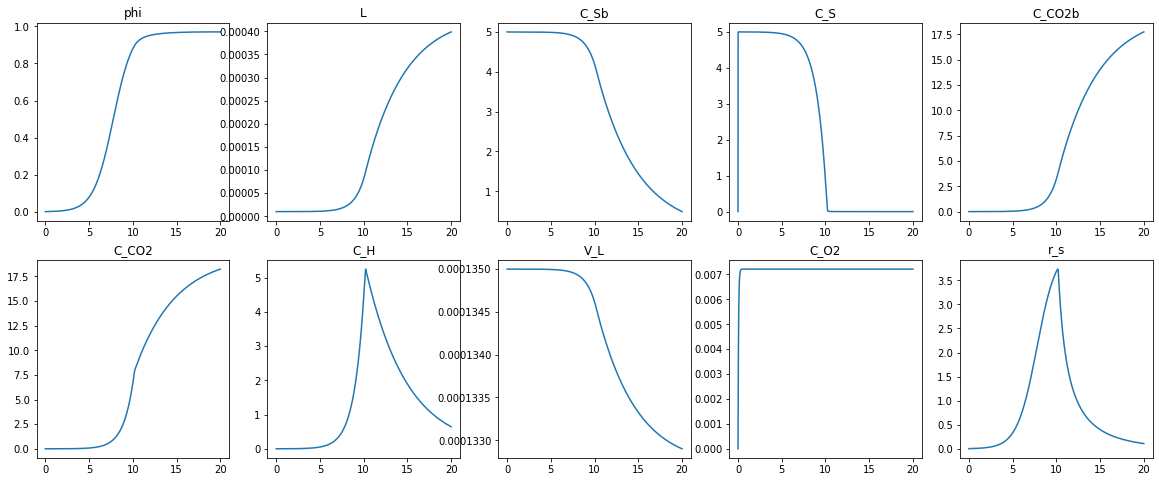

In [250]:
I = (0.001,1e-5,5,0,0,0,1e-7,135e-6,0)
t = np.arange(0,20,0.01)
res = solve(model_A, I, t)
#plt.plot(t,res[:,5])
plt.figure(figsize=(20,8))
names = ['phi','L','C_Sb','C_S','C_CO2b','C_CO2','C_H','V_L','C_O2']
for n in range(1,10):
    plt.subplot(2,5,n)
    plt.plot(t,res[:,n-1])
    plt.title(names[n-1])

r_max = 4.2
K_s = 1.27e-3
r_s = r_max * res[:,3] / (K_s + res[:,3]) * res[:,0]
plt.subplot(2,5,10)
plt.plot(t,r_s)
plt.title('r_s')

In [225]:
C_S[1:5]

array([4.99748479, 4.99742475, 4.99735911, 4.99728734])

In [245]:

b = 120
i_0_ref = 0.02
C_S = res[:,3]
d_m = 4.5
k_m = 1.7
d_cell = 2.5e-2
k_aq = 3500
F = 96450
C_Sb = res[:,2]
L_l = 2e-4
R = 8.314
T = 303
E_0_anode = 0.340
C_CO2 = res[:,5]
C_H = res[:,6]
E_0_cathode = 1299
C_O2 = res[:,8]
A_m = 54e-4
V_C = 680
R_ext = 500

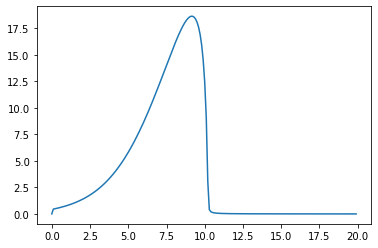

In [246]:
i_cell = []

def get_current(c_S,c_CO2,c_H):

    if c_S == 0:
        return 0

    E_A = E_0_anode - R * T * np.log(((c_CO2 / 44) ** 3) * (c_H ** 12 )/ (c_S/90)) / (12 * F)
    #print(R * T * np.log(((c_CO2 / 44) ** 3) * (c_H ** 12 )/ (c_S/90)) / (12 * F))
    R_int = d_m / k_m + d_cell / k_aq
    E_A = 1000 * E_A
    #print(E_A)
    def equation(i):
        return 2 * i_0_ref * c_S * np.sinh(2.303 * (V_C - i * A_m * (R_int + R_ext) - E_A) / b) - i
    i = fsolve(equation,60)[0]
    return i
for n in range(np.shape(C_S)[0]):
    i_cell.append(get_current(C_S[n],C_CO2[n],C_H[n]))
plt.plot(t,i_cell)


In [ ]:

i = 65
eta_act = b * np.arcsinh(i / (2 * i_0_ref * C_S[50])) / 2.303
eta_ohm = (d_m / k_m + d_cell / k_aq) * i
i_l = 8 * F * D_s * C_Sb[50] / L_l 
eta_con = R * T * np.log(i_l / (i_l - i))
E_anode = -E_0_anode - R * T * np.log(C_CO2[50] ** 3 * C_H[50] ** 12 / C_S[50]) / (12 * F)
E_cathode = E_0_cathode - R * T * np.log(1 / (C_O2[50] * (1e-7) ** 4) ) / (4 * F)
ic(E_cathode-E_anode)
ic(eta_act)
ic(eta_con)
ic(eta_ohm)
E  =  E_cathode-E_anode-eta_ohm-eta_act-eta_con
ic(E)
def current(ini):
    c_S, c_Sb, c_CO2, c_H, c_O2 = ini
    def equ(i):
        eta_act = b * np.arcsinh(i / (2 * i_0_ref * c_S)) / 2.303
        eta_ohm = (d_m / k_m + d_cell / k_aq) * i
        i_l = 8 * F * D_s * c_Sb / L_l 
        eta_con = R * T * np.log(i_l / (i_l - i))
        E_anode = -E_0_anode - R * T * np.log(c_CO2 ** 3 * c_H ** 12 / c_S) / (12 * F)
        E_cathode = E_0_cathode - R * T * np.log(1 / (c_O2 * (1e-7) ** 4) ) / (4 * F)
        return E_cathode - E_anode - eta_act - eta_con - eta_ohm - 100 * A_m * i
    
    i = fsolve(equ,180)[0]
    return i * A_m
print(current((C_S[2],C_Sb[2],C_CO2[2],C_H[2],C_O2[2])))
current_i = []
E = []
for n in range(np.shape(C_S)[0]):
    current_i.append(current((C_S[n],C_Sb[n],C_CO2[n],C_H[n],C_O2[n])))
    eta_act = b * np.arcsinh(i / (2 * i_0_ref * C_S[n])) / 2.303
    eta_ohm = (d_m / k_m + d_cell / k_aq) * i
    i_l = 8 * F * D_s * C_Sb[n] / L_l 
    eta_con = R * T * np.log(i_l / (i_l - i))
    E_anode = -E_0_anode - R * T * np.log(C_CO2[n] ** 3 * C_H[n] ** 12 / C_S[n]) / (12 * F)
    E_cathode = E_0_cathode - R * T * np.log(1 / (C_O2[n] * (1e-7) ** 4) ) / (4 * F)
    E.append(E_cathode - E_anode - eta_act - eta_con - eta_ohm)
plt.plot(t,E)

In [9]:
def test(alpha):

    def equ(x):
        return x ** 2+alpha*x -3
    print(fsolve(equ,2)[0])

for alpha in range(-3,3):
    test(alpha)

3.7912878474779057
3.0000000000000004
2.302775637731995
1.7320508075688819
1.3027756377319946
1.0000000000000084


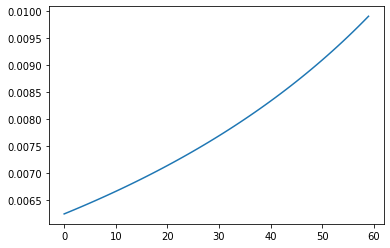

In [6]:
plt.plot(t,np.arcsin(1/np.arange(160,100,-1)))

In [8]:
d_m = 4.5
k_m = 1.7
d_cell = 2.5e-2
k_aq = 3500
d_m / k_m + d_cell / k_aq

2.6470659663865543

In [17]:
np.random.random()

0.45498386179236094